In [1]:
%load_ext autoreload
%autoreload

import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GroupKFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from equationmodel_ann import ann_mlp_regression, prediction_rmse_error, ann_linear_compare_graph
from util import ADD_data_loader, combineDF, filteringDF, getFreeSpacePathLoss, makeXforGraphWithGroupingFrequency,\
                makeXforGraph, inverseScale, samplingData, normalizeData,train_2d_graph, train_3d_graph

desired_width=620
pd.set_option('display.width', desired_width)
pd.set_option('display.max_columns',30)

In [2]:
%autoreload

iksan_fileList = {'../data/PLdata_iksan_wt_400.csv':[('frequency', 400), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_iksan_wt_1399.csv':[('frequency', 1399), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_iksan_wt_2249.csv':[('frequency', 2249), ('heightTB',30), ('heightB',15), ('heightM',2)]}
nonsan_fileList = {'../data/PLdata_nonsan_wt_400.csv':[('frequency', 400), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_nonsan_wt_1399.csv':[('frequency', 1399), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_nonsan_wt_2249.csv':[('frequency', 2249), ('heightTB',30), ('heightB',15), ('heightM',2)]}
paju_fileList = {'../data/PLdata_paju_wt_400.csv':[('frequency', 400), ('heightTB',100), ('heightB',7), ('heightM',2)],
            '../data/PLdata_paju_wt_1399.csv':[('frequency', 1399), ('heightTB',100), ('heightB',7), ('heightM',2)],
            '../data/PLdata_paju_wt_2249.csv':[('frequency', 2249), ('heightTB',100), ('heightB',7), ('heightM',2)]}

addIksan = ADD_data_loader(iksan_fileList)
print("Iksan data:",addIksan.shape)
print("")
addNonsan = ADD_data_loader(nonsan_fileList)
print("Nonsan data:",addNonsan.shape)
print("")
addPaju = ADD_data_loader(paju_fileList)
print("Paju data:",addPaju.shape)
print("")

# print(addIksan.describe())
# print(addNonsan.describe())
# print(addPaju.describe())

addData = combineDF([addIksan, addNonsan, addPaju])
print("antenna_b height filtering-before(data count):",addData.shape)
addData = filteringDF(addData, 'heightTM', [10,100])
print("antenna_b height filtering-after(data count):",addData.shape)

print("freespace pathloss filtering-before(data count):",addData.shape)
addData['freePathloss'] = getFreeSpacePathLoss(addData['distance'],addData['frequency'])
addData = addData[addData['pathloss'] >= addData['freePathloss']]
print("freespace pathloss filtering-after(data count):",addData.shape)

# print("ADD data sample:\n",addData.head())

print("\nADD data description")
print(addData[['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'extendedHeightTratio', 'logAntennaMulLogDistance', 'pathloss']].describe())
print("\nCovariance Matrix - ADD data")
print(addData[['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'extendedHeightTratio', 'logAntennaMulLogDistance', 'pathloss']].cov())
print("\nSample - ADD data")
print(addData[['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'extendedHeightTratio', 'logAntennaMulLogDistance', 'pathloss']].head())


ADD data preprocessing
../data/PLdata_iksan_wt_400.csv: distance filtering(before):(109210, 4)
../data/PLdata_iksan_wt_400.csv: distance filtering(after):(10396, 4)
../data/PLdata_iksan_wt_1399.csv: distance filtering(before):(109060, 4)
../data/PLdata_iksan_wt_1399.csv: distance filtering(after):(10396, 4)
../data/PLdata_iksan_wt_2249.csv: distance filtering(before):(108873, 4)
../data/PLdata_iksan_wt_2249.csv: distance filtering(after):(10396, 4)
Combined data set: (31188, 8)
type filtering(before):(31188, 8)
type filtering(after):(21210, 8)
Dataframe before add new terms: (21210, 8)
Dataframe after add constant feature: (21210, 18)
Iksan data: (21210, 18)

ADD data preprocessing
../data/PLdata_nonsan_wt_1399.csv: distance filtering(before):(114455, 4)
../data/PLdata_nonsan_wt_1399.csv: distance filtering(after):(14603, 4)
../data/PLdata_nonsan_wt_2249.csv: distance filtering(before):(114341, 4)
../data/PLdata_nonsan_wt_2249.csv: distance filtering(after):(14603, 4)
../data/PLdata_no

In [3]:
%autoreload

addDataSample = samplingData(addData[['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'extendedHeightTratio', 'logAntennaMulLogDistance', 'pathloss']], 0.1)
addDataSample.sort_values(by=['logDistance'])

manual_normalize = True

X = normalizeData(addDataSample[['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'extendedHeightTratio', 'logAntennaMulLogDistance']], scaler = 'standard', auto = not manual_normalize)
Y = np.array(addDataSample[['pathloss']])

data distribution(before)
       logDistance  logFrequency   logHeightB   logHeightM  extendedHeightTratio  logAntennaMulLogDistance     pathloss
count  79125.00000   79125.00000  79125.00000  79125.00000           79125.00000               79125.00000  79125.00000
mean       0.30807       3.03282      1.05325      0.30103               0.46810                   0.32494    127.46660
std        0.11901       0.31582      0.15991      0.00000               0.26449                   0.13568     16.61257
min        0.00003       2.60206      0.84510      0.30103               0.11215                   0.00004     85.05800
25%        0.23252       2.60206      0.84510      0.30103               0.24112                   0.23656    114.90700
50%        0.32884       3.14582      1.17609      0.30103               0.41111                   0.33415    127.16800
75%        0.39827       3.35199      1.17609      0.30103               0.64444                   0.41372    140.50700
max        0.4

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2880: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


normalization distribution(after):
       logDistance  logFrequency  logHeightB  logHeightM  extendedHeightTratio  logAntennaMulLogDistance
count   7912.00000    7912.00000  7912.00000  7912.00000            7912.00000                7912.00000
mean       0.30684       0.30300     0.10526     0.30103               0.46394                   0.32354
std        0.11874       0.03160     0.01601     0.00000               0.26104                   0.13514
min        0.00031       0.26021     0.08451     0.30103               0.11215                   0.00032
25%        0.23216       0.26021     0.08451     0.30103               0.23645                   0.23633
50%        0.32849       0.31458     0.11761     0.30103               0.41111                   0.33380
75%        0.39617       0.33520     0.11761     0.30103               0.64222                   0.41148
max        0.47706       0.33520     0.11761     0.30103               1.87111                   0.56107


In [4]:
kf = KFold(n_splits=5, shuffle=False)
kf.get_n_splits(X)

modelList = []
dataSet = []
i = 1
for train_index, test_index in kf.split(X):
#     print("TRAIN index:", train_index, "TEST index:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    model = ann_mlp_regression(X_train, y_train.flatten(), (60,), activation='logistic', optimizer='lbfgs')

#     trainError = prediction_rmse_error(model.predict(X_train), y_train)
#     testError = prediction_rmse_error(model.predict(X_test), y_test)
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    trainError = np.sqrt(mean_squared_error(y_train, pred_train))
    testError = np.sqrt(mean_squared_error(y_test, pred_test))

    print("ANN-Model-"+str(i)+"-train error(RMSE):", trainError)
    print("ANN-Model-"+str(i)+"-test error(RMSE):", testError)    
    
    dataSet.append([X_train,y_train,X_test,y_test, trainError, testError])
    
    modelList.append(model)
    filename = 'model/ann_model_' + str(i) + '.sav'
    pickle.dump(model, open(filename, 'wb'))
    i+=1

loss: 57.70715441132496
ANN-Model-1-train error(RMSE): 10.742817361125441
ANN-Model-1-test error(RMSE): 11.162634360372376
loss: 57.50421956272405
ANN-Model-2-train error(RMSE): 10.723734720322145
ANN-Model-2-test error(RMSE): 11.10289963152522
loss: 59.68579833902971
ANN-Model-3-train error(RMSE): 10.925526445660676
ANN-Model-3-test error(RMSE): 10.979310873193645
loss: 61.81451238002052
ANN-Model-4-train error(RMSE): 11.118586474894286
ANN-Model-4-test error(RMSE): 11.523713118118053
loss: 62.34800657993921
ANN-Model-5-train error(RMSE): 11.16646750606209
ANN-Model-5-test error(RMSE): 11.577605475459663


Group-  0.26Ghz Data shape:(2120, 7)
Group-  0.31Ghz Data shape:(2143, 7)
Group-  0.34Ghz Data shape:(2066, 7)
For 'logDistance' column, min value:  0.00, max value:  0.48
For 'logAntennaMulLogDistance' column, min value:  0.00, max value:  0.56
For 'logDistance' column, min value:  0.00, max value:  0.48
For 'logAntennaMulLogDistance' column, min value:  0.00, max value:  0.56
For 'logDistance' column, min value:  0.00, max value:  0.48
For 'logAntennaMulLogDistance' column, min value:  0.00, max value:  0.56


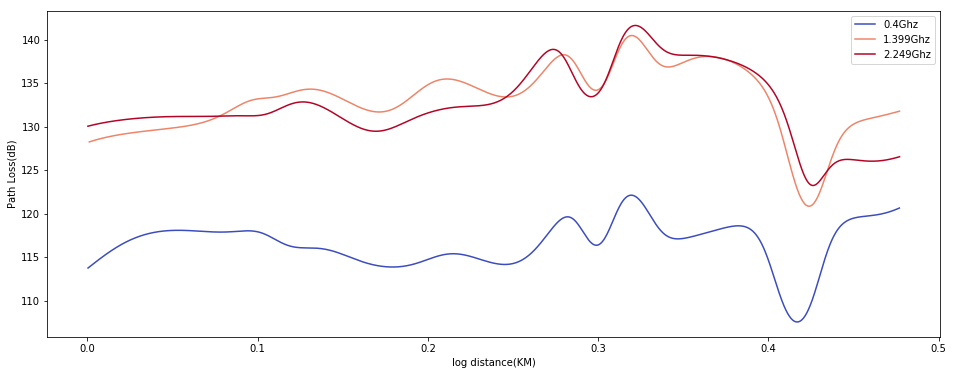

Group-  0.26Ghz Data shape:(2131, 7)
Group-  0.31Ghz Data shape:(2125, 7)
Group-  0.34Ghz Data shape:(2073, 7)
For 'logDistance' column, min value:  0.00, max value:  0.48
For 'logAntennaMulLogDistance' column, min value:  0.00, max value:  0.56
For 'logDistance' column, min value:  0.00, max value:  0.48
For 'logAntennaMulLogDistance' column, min value:  0.00, max value:  0.56
For 'logDistance' column, min value:  0.00, max value:  0.48
For 'logAntennaMulLogDistance' column, min value:  0.00, max value:  0.56


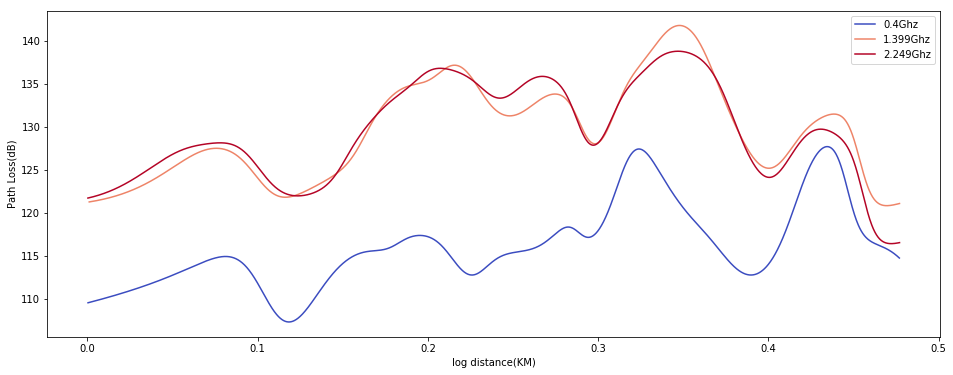

Group-  0.26Ghz Data shape:(2112, 7)
Group-  0.31Ghz Data shape:(2160, 7)
Group-  0.34Ghz Data shape:(2058, 7)
For 'logDistance' column, min value:  0.00, max value:  0.48
For 'logAntennaMulLogDistance' column, min value:  0.00, max value:  0.56
For 'logDistance' column, min value:  0.00, max value:  0.48
For 'logAntennaMulLogDistance' column, min value:  0.00, max value:  0.56
For 'logDistance' column, min value:  0.00, max value:  0.48
For 'logAntennaMulLogDistance' column, min value:  0.00, max value:  0.56


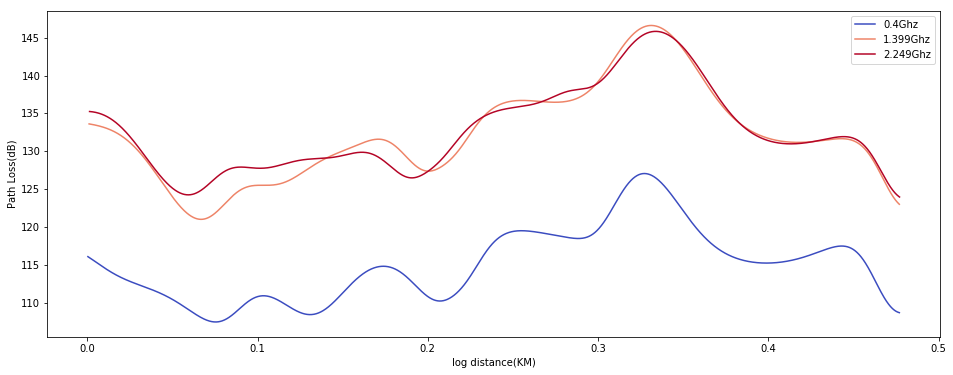

Group-  0.26Ghz Data shape:(2122, 7)
Group-  0.31Ghz Data shape:(2150, 7)
Group-  0.34Ghz Data shape:(2058, 7)
For 'logDistance' column, min value:  0.00, max value:  0.48
For 'logAntennaMulLogDistance' column, min value:  0.00, max value:  0.56
For 'logDistance' column, min value:  0.00, max value:  0.48
For 'logAntennaMulLogDistance' column, min value:  0.00, max value:  0.56
For 'logDistance' column, min value:  0.00, max value:  0.48
For 'logAntennaMulLogDistance' column, min value:  0.00, max value:  0.56


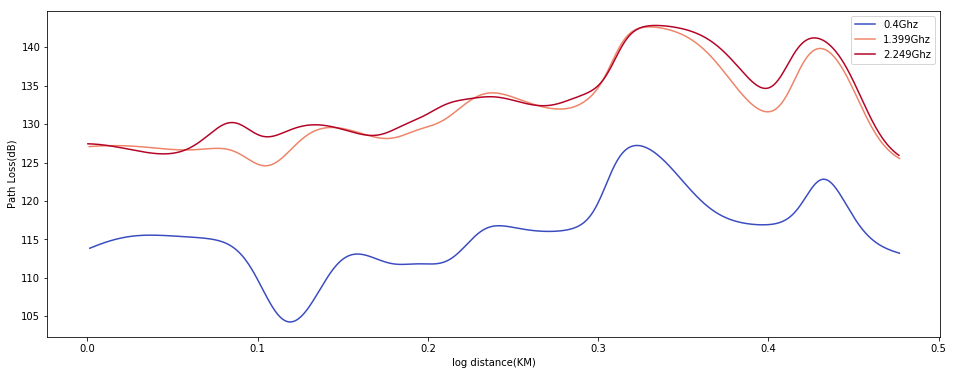

Group-  0.26Ghz Data shape:(2155, 7)
Group-  0.31Ghz Data shape:(2142, 7)
Group-  0.34Ghz Data shape:(2033, 7)
For 'logDistance' column, min value:  0.00, max value:  0.48
For 'logAntennaMulLogDistance' column, min value:  0.00, max value:  0.56
For 'logDistance' column, min value:  0.00, max value:  0.48
For 'logAntennaMulLogDistance' column, min value:  0.00, max value:  0.56
For 'logDistance' column, min value:  0.00, max value:  0.48
For 'logAntennaMulLogDistance' column, min value:  0.00, max value:  0.56


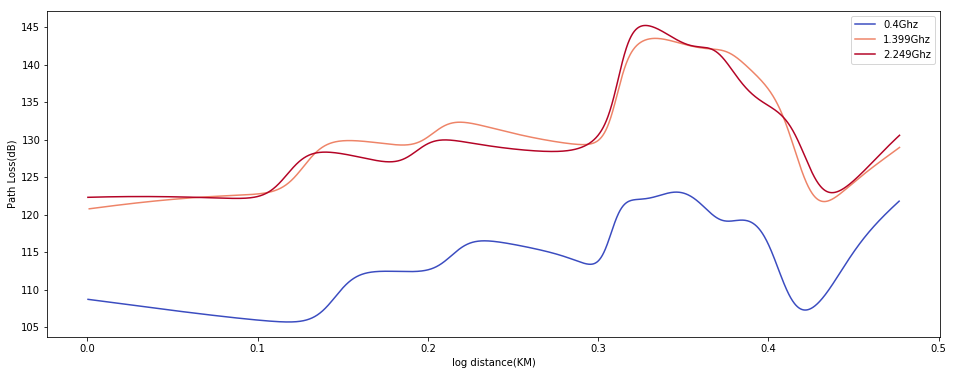

In [5]:
%autoreload
i = 1
for X_train,y_train,X_test,y_test, trainError, testError in dataSet:
    data = makeXforGraphWithGroupingFrequency(pd.DataFrame(X_train, columns=['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'extendedHeightTratio', 'logAntennaMulLogDistance']),
                         pd.DataFrame(y_train, columns=['pathloss']), ['logHeightB', 'logHeightM', 'extendedHeightTratio'])

    model = pickle.load(open("model/ann_model_"+ str(i) +".sav", 'rb'))

    graphX = data[0]
    graphY = data[1]
    train_2d_graph(model, graphX, graphY, ['logDistance', 'logAntennaMulLogDistance'])
    i+=1

3D graph for log distance and log frequency - trainset #1
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'extendedHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency   logHeightB   logHeightM  extendedHeightTratio  logAntennaMulLogDistance
count  1.00000e+04   10000.00000  10000.00000  10000.00000           1.00000e+04               10000.00000
mean   3.06988e-01       0.29770      0.10524      0.30103           4.64061e-01                   0.28070
std    1.11028e-16       0.02187      0.00000      0.00000           1.66542e-16                   0.16351
min    3.06988e-01       0.26021      0.10524      0.30103           4.64061e-01                   0.00032
25%    3.06988e-01       0.27895      0.10524      0.30103           4.64061e-01                   0.14051
50%    3.06988e-01       0.29770      0.10524      0.30103           4.64061e-01                   0.28070
75%    3.06988e-01      

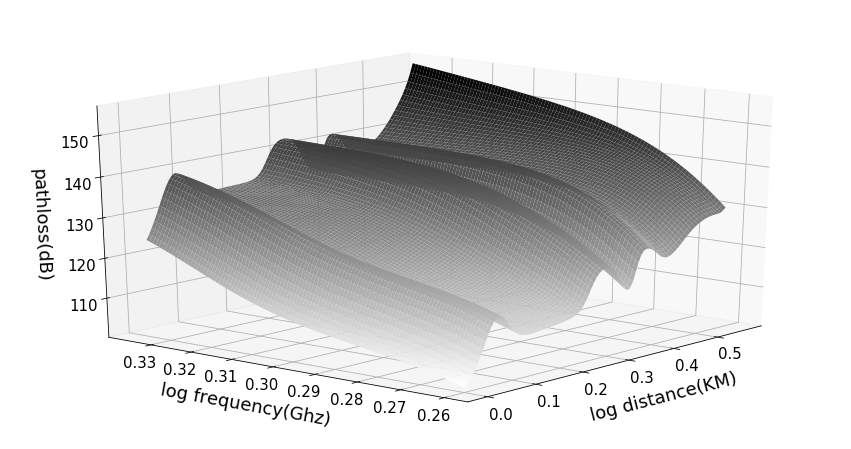

3D graph for log distance and log frequency - trainset #2
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'extendedHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency   logHeightB   logHeightM  extendedHeightTratio  logAntennaMulLogDistance
count  10000.00000   10000.00000  1.00000e+04  10000.00000           1.00000e+04               10000.00000
mean       0.30759       0.29770  1.05371e-01      0.30103           4.63841e-01                   0.28070
std        0.00000       0.02187  1.38785e-17      0.00000           1.11028e-16                   0.16351
min        0.30759       0.26021  1.05371e-01      0.30103           4.63841e-01                   0.00032
25%        0.30759       0.27895  1.05371e-01      0.30103           4.63841e-01                   0.14051
50%        0.30759       0.29770  1.05371e-01      0.30103           4.63841e-01                   0.28070
75%        0.30759      

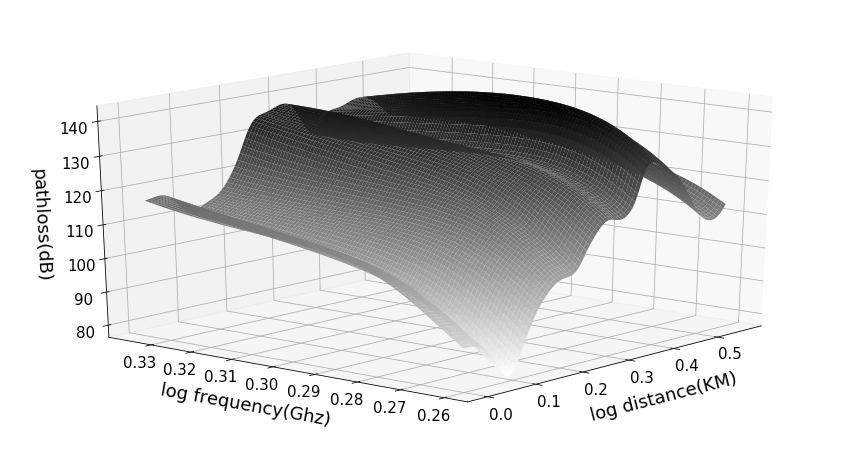

3D graph for log distance and log frequency - trainset #3
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'extendedHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency   logHeightB   logHeightM  extendedHeightTratio  logAntennaMulLogDistance
count  10000.00000   10000.00000  1.00000e+04  10000.00000           10000.00000               10000.00000
mean       0.30738       0.29770  1.05180e-01      0.30103               0.46269                   0.28070
std        0.00000       0.02187  1.38785e-17      0.00000               0.00000                   0.16351
min        0.30738       0.26021  1.05180e-01      0.30103               0.46269                   0.00032
25%        0.30738       0.27895  1.05180e-01      0.30103               0.46269                   0.14051
50%        0.30738       0.29770  1.05180e-01      0.30103               0.46269                   0.28070
75%        0.30738      

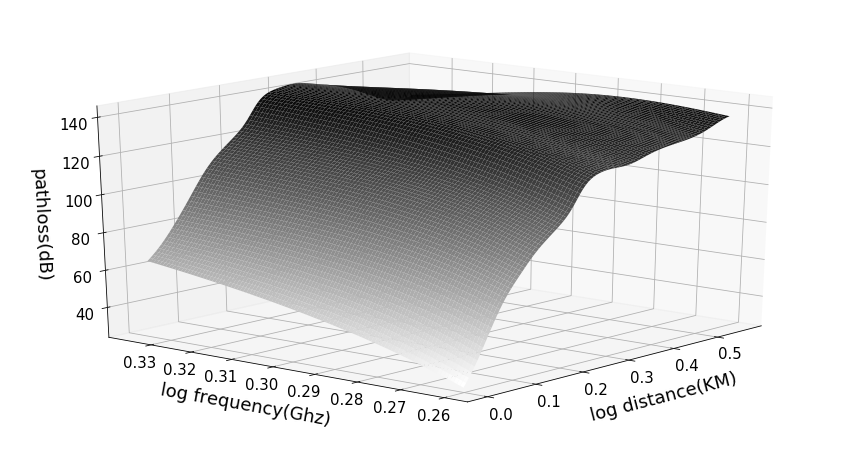

3D graph for log distance and log frequency - trainset #4
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'extendedHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency   logHeightB   logHeightM  extendedHeightTratio  logAntennaMulLogDistance
count  10000.00000   10000.00000  1.00000e+04  10000.00000           1.00000e+04               10000.00000
mean       0.30598       0.29770  1.05253e-01      0.30103           4.65183e-01                   0.28065
std        0.00000       0.02187  2.77570e-17      0.00000           2.22056e-16                   0.16346
min        0.30598       0.26021  1.05253e-01      0.30103           4.65183e-01                   0.00036
25%        0.30598       0.27895  1.05253e-01      0.30103           4.65183e-01                   0.14051
50%        0.30598       0.29770  1.05253e-01      0.30103           4.65183e-01                   0.28065
75%        0.30598      

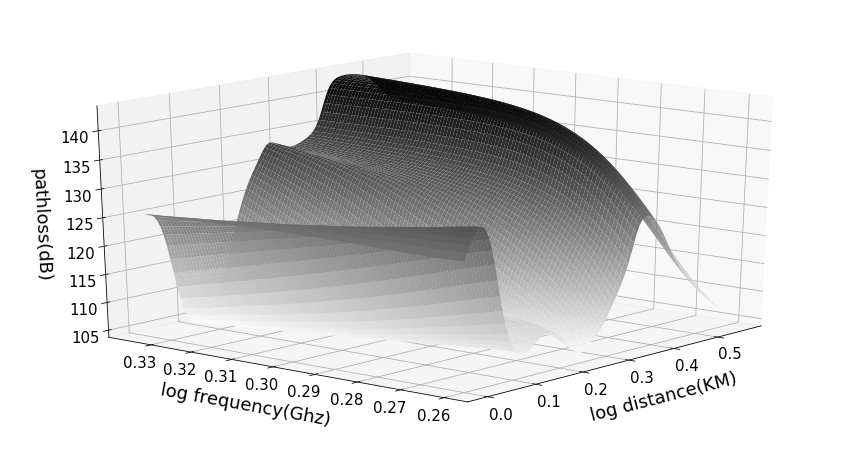

3D graph for log distance and log frequency - trainset #5
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'extendedHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency   logHeightB   logHeightM  extendedHeightTratio  logAntennaMulLogDistance
count  1.00000e+04   10000.00000  1.00000e+04  10000.00000           1.00000e+04               10000.00000
mean   3.06252e-01       0.29770  1.05237e-01      0.30103           4.63925e-01                   0.28070
std    5.55139e-17       0.02187  1.38785e-17      0.00000           1.11028e-16                   0.16351
min    3.06252e-01       0.26021  1.05237e-01      0.30103           4.63925e-01                   0.00032
25%    3.06252e-01       0.27895  1.05237e-01      0.30103           4.63925e-01                   0.14051
50%    3.06252e-01       0.29770  1.05237e-01      0.30103           4.63925e-01                   0.28070
75%    3.06252e-01      

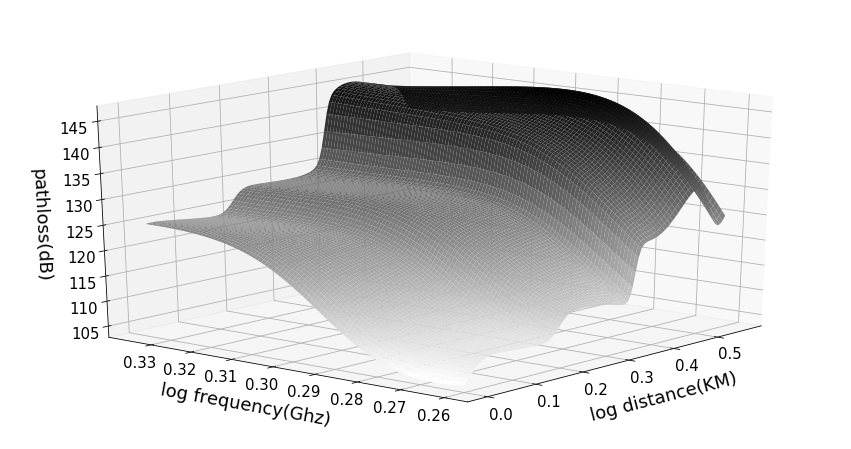

In [23]:
%autoreload
i = 1
for X_train,y_train,X_test,y_test, trainError, testError in dataSet:
    print("3D graph for log distance and log frequency - trainset #{}".format(i))
    targetCols = ['logAntennaMulLogDistance', 'logFrequency']
    xLabel,yLabel,zLabel = "log distance(KM)","log frequency(Ghz)","pathloss(dB)"
    data = makeXforGraph(pd.DataFrame(X_train, columns=['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'extendedHeightTratio', 'logAntennaMulLogDistance']),
                         pd.DataFrame(y_train, columns=['pathloss']), targetCols)

    model = pickle.load(open("model/ann_model_"+ str(i) +".sav", 'rb'))

    graphX = data[0]
    graphY = data[1]
    train_3d_graph(model, graphX, graphY, targetCols, xLabel, yLabel, zLabel)
    i+=1

3D graph for log distance and log antenna height B+TB/M+TM ratio - trainset #1
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'extendedHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency   logHeightB   logHeightM  extendedHeightTratio  logAntennaMulLogDistance
count  1.00000e+04   1.00000e+04  10000.00000  10000.00000           10000.00000               10000.00000
mean   3.06988e-01   3.03098e-01      0.10524      0.30103               0.99163                   0.28070
std    1.11028e-16   5.55139e-17      0.00000      0.00000               0.51290                   0.16351
min    3.06988e-01   3.03098e-01      0.10524      0.30103               0.11215                   0.00032
25%    3.06988e-01   3.03098e-01      0.10524      0.30103               0.55189                   0.14051
50%    3.06988e-01   3.03098e-01      0.10524      0.30103               0.99163                   0.28070
75%

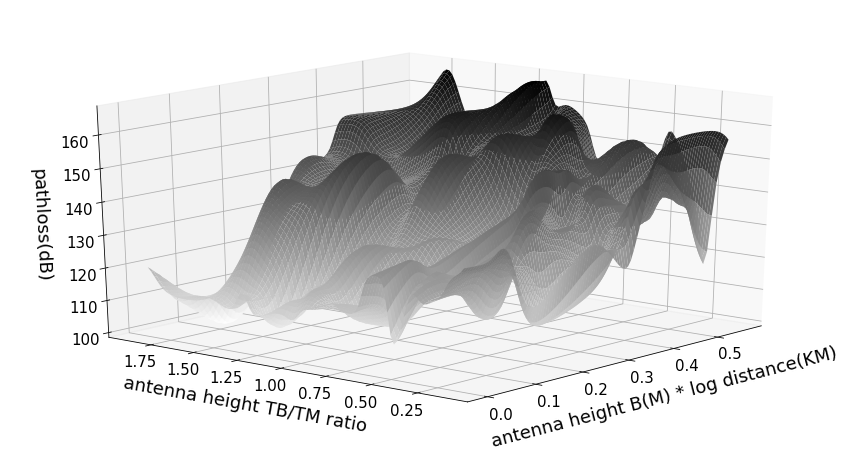

3D graph for log distance and log antenna height B+TB/M+TM ratio - trainset #2
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'extendedHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency   logHeightB   logHeightM  extendedHeightTratio  logAntennaMulLogDistance
count  10000.00000   1.00000e+04  1.00000e+04  10000.00000           10000.00000               10000.00000
mean       0.30759   3.03026e-01  1.05371e-01      0.30103               0.99163                   0.28070
std        0.00000   5.55139e-17  1.38785e-17      0.00000               0.51290                   0.16351
min        0.30759   3.03026e-01  1.05371e-01      0.30103               0.11215                   0.00032
25%        0.30759   3.03026e-01  1.05371e-01      0.30103               0.55189                   0.14051
50%        0.30759   3.03026e-01  1.05371e-01      0.30103               0.99163                   0.28070
75%

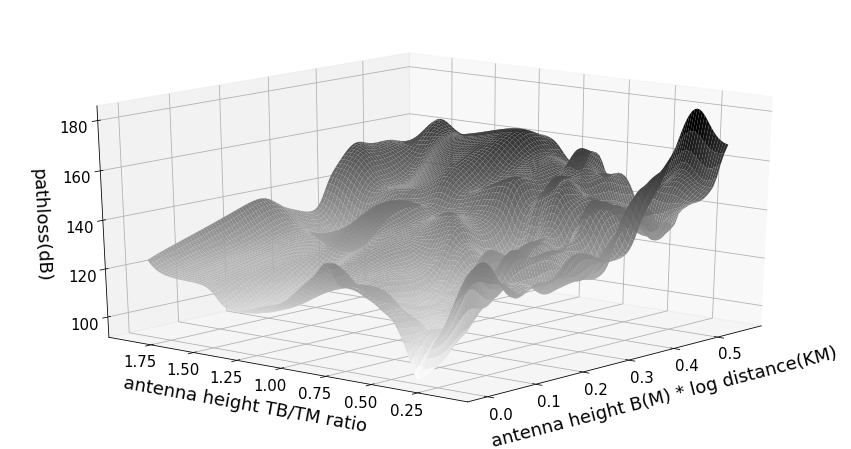

3D graph for log distance and log antenna height B+TB/M+TM ratio - trainset #3
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'extendedHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency   logHeightB   logHeightM  extendedHeightTratio  logAntennaMulLogDistance
count  10000.00000   1.00000e+04  1.00000e+04  10000.00000           10000.00000               10000.00000
mean       0.30738   3.03142e-01  1.05180e-01      0.30103               0.99163                   0.28070
std        0.00000   5.55139e-17  1.38785e-17      0.00000               0.51290                   0.16351
min        0.30738   3.03142e-01  1.05180e-01      0.30103               0.11215                   0.00032
25%        0.30738   3.03142e-01  1.05180e-01      0.30103               0.55189                   0.14051
50%        0.30738   3.03142e-01  1.05180e-01      0.30103               0.99163                   0.28070
75%

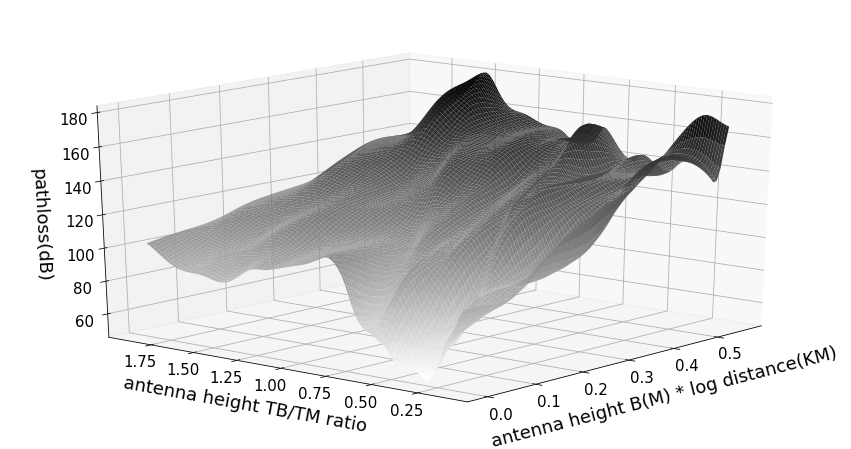

3D graph for log distance and log antenna height B+TB/M+TM ratio - trainset #4
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'extendedHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency   logHeightB   logHeightM  extendedHeightTratio  logAntennaMulLogDistance
count  10000.00000   1.00000e+04  1.00000e+04  10000.00000           10000.00000               10000.00000
mean       0.30598   3.03056e-01  1.05253e-01      0.30103               0.99163                   0.28065
std        0.00000   5.55139e-17  2.77570e-17      0.00000               0.51290                   0.16346
min        0.30598   3.03056e-01  1.05253e-01      0.30103               0.11215                   0.00036
25%        0.30598   3.03056e-01  1.05253e-01      0.30103               0.55189                   0.14051
50%        0.30598   3.03056e-01  1.05253e-01      0.30103               0.99163                   0.28065
75%

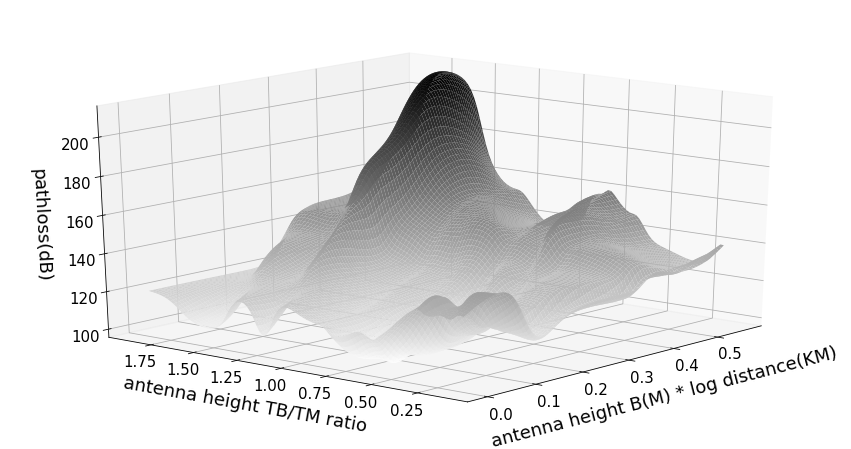

3D graph for log distance and log antenna height B+TB/M+TM ratio - trainset #5
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'extendedHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency   logHeightB   logHeightM  extendedHeightTratio  logAntennaMulLogDistance
count  1.00000e+04   1.00000e+04  1.00000e+04  10000.00000           10000.00000               10000.00000
mean   3.06252e-01   3.02692e-01  1.05237e-01      0.30103               0.97385                   0.28070
std    5.55139e-17   5.55139e-17  1.38785e-17      0.00000               0.50253                   0.16351
min    3.06252e-01   3.02692e-01  1.05237e-01      0.30103               0.11215                   0.00032
25%    3.06252e-01   3.02692e-01  1.05237e-01      0.30103               0.54300                   0.14051
50%    3.06252e-01   3.02692e-01  1.05237e-01      0.30103               0.97385                   0.28070
75%

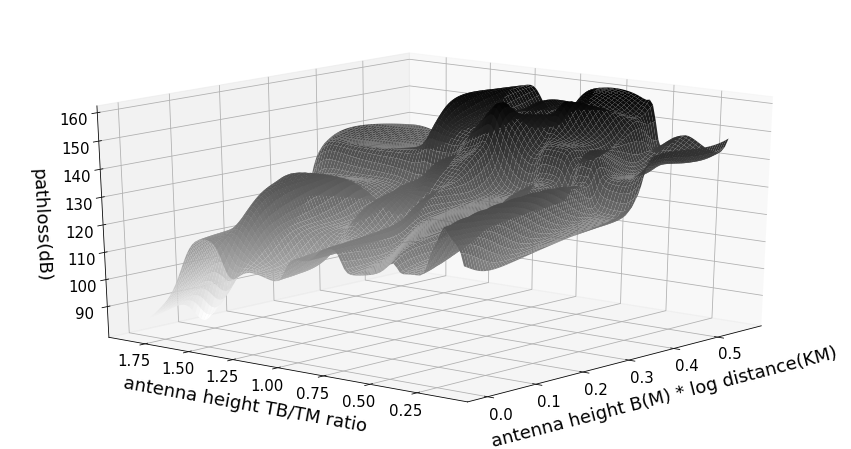

In [26]:
%autoreload
i = 1
for X_train,y_train,X_test,y_test, trainError, testError in dataSet:
    print("3D graph for log distance and log antenna height B+TB/M+TM ratio - trainset #{}".format(i))
    targetCols = ['logAntennaMulLogDistance', 'extendedHeightTratio']
    xLabel,yLabel,zLabel = "antenna height B(M) * log distance(KM)","antenna height TB/TM ratio","pathloss(dB)"
    data = makeXforGraph(pd.DataFrame(X_train, columns=['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'extendedHeightTratio', 'logAntennaMulLogDistance']),
                         pd.DataFrame(y_train, columns=['pathloss']), targetCols)

    model = pickle.load(open("model/ann_model_"+ str(i) +".sav", 'rb'))

    graphX = data[0]
    graphY = data[1]
    train_3d_graph(model, graphX, graphY, targetCols, xLabel, yLabel, zLabel)
    i+=1

3D graph for log distance and log antenna height B ratio - trainset #1
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'extendedHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency   logHeightB   logHeightM  extendedHeightTratio  logAntennaMulLogDistance
count  1.00000e+04   1.00000e+04  10000.00000  10000.00000           1.00000e+04               10000.00000
mean   3.06988e-01   3.03098e-01      0.10106      0.30103           4.64061e-01                   0.28070
std    1.11028e-16   5.55139e-17      0.00965      0.00000           1.66542e-16                   0.16351
min    3.06988e-01   3.03098e-01      0.08451      0.30103           4.64061e-01                   0.00032
25%    3.06988e-01   3.03098e-01      0.09278      0.30103           4.64061e-01                   0.14051
50%    3.06988e-01   3.03098e-01      0.10106      0.30103           4.64061e-01                   0.28070
75%    3.06

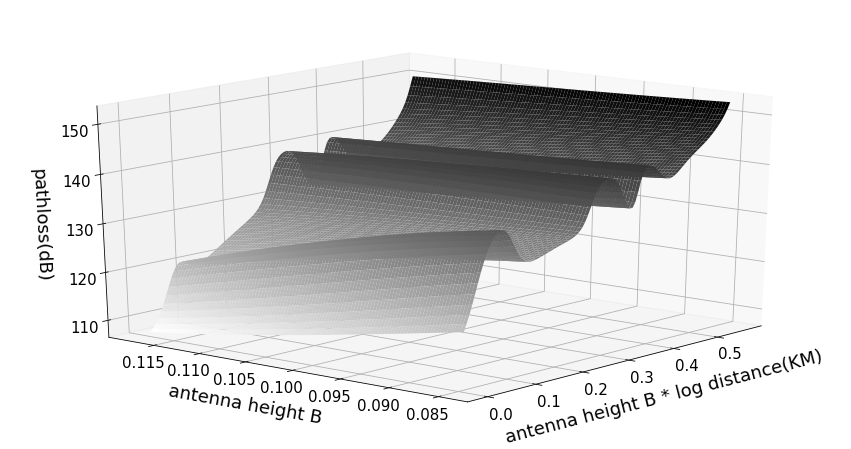

3D graph for log distance and log antenna height B ratio - trainset #2
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'extendedHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency   logHeightB   logHeightM  extendedHeightTratio  logAntennaMulLogDistance
count  10000.00000   1.00000e+04  10000.00000  10000.00000           1.00000e+04               10000.00000
mean       0.30759   3.03026e-01      0.10106      0.30103           4.63841e-01                   0.28070
std        0.00000   5.55139e-17      0.00965      0.00000           1.11028e-16                   0.16351
min        0.30759   3.03026e-01      0.08451      0.30103           4.63841e-01                   0.00032
25%        0.30759   3.03026e-01      0.09278      0.30103           4.63841e-01                   0.14051
50%        0.30759   3.03026e-01      0.10106      0.30103           4.63841e-01                   0.28070
75%        

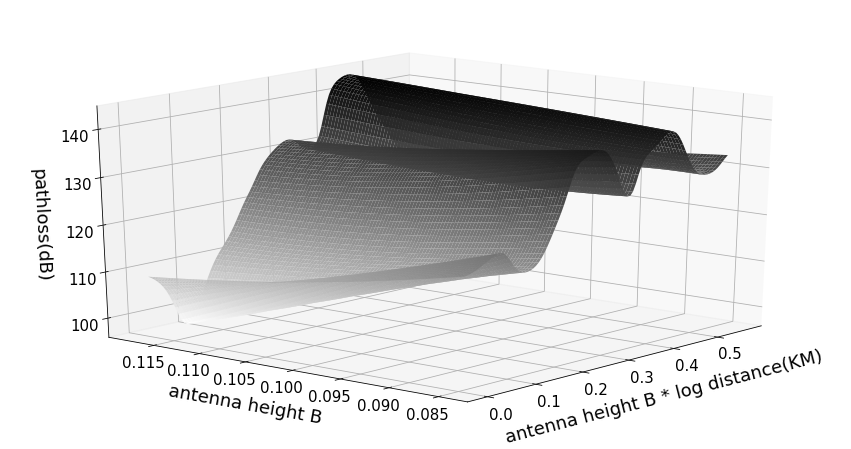

3D graph for log distance and log antenna height B ratio - trainset #3
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'extendedHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency   logHeightB   logHeightM  extendedHeightTratio  logAntennaMulLogDistance
count  10000.00000   1.00000e+04  10000.00000  10000.00000           10000.00000               10000.00000
mean       0.30738   3.03142e-01      0.10106      0.30103               0.46269                   0.28070
std        0.00000   5.55139e-17      0.00965      0.00000               0.00000                   0.16351
min        0.30738   3.03142e-01      0.08451      0.30103               0.46269                   0.00032
25%        0.30738   3.03142e-01      0.09278      0.30103               0.46269                   0.14051
50%        0.30738   3.03142e-01      0.10106      0.30103               0.46269                   0.28070
75%        

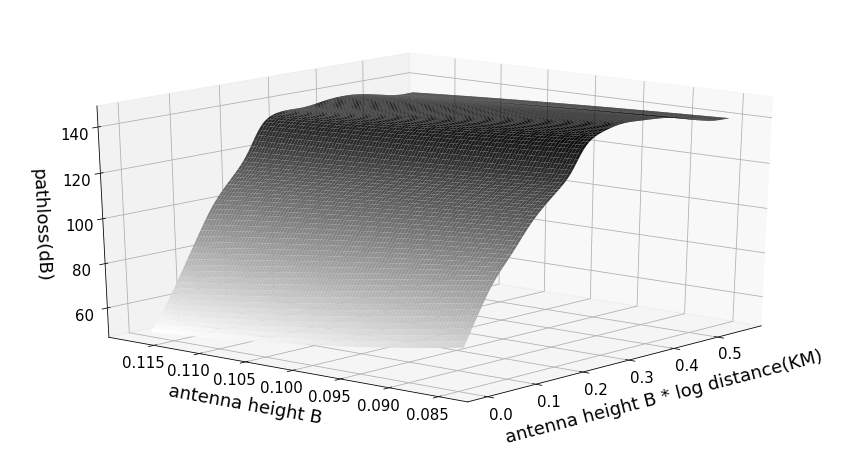

3D graph for log distance and log antenna height B ratio - trainset #4
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'extendedHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency   logHeightB   logHeightM  extendedHeightTratio  logAntennaMulLogDistance
count  10000.00000   1.00000e+04  10000.00000  10000.00000           1.00000e+04               10000.00000
mean       0.30598   3.03056e-01      0.10106      0.30103           4.65183e-01                   0.28065
std        0.00000   5.55139e-17      0.00965      0.00000           2.22056e-16                   0.16346
min        0.30598   3.03056e-01      0.08451      0.30103           4.65183e-01                   0.00036
25%        0.30598   3.03056e-01      0.09278      0.30103           4.65183e-01                   0.14051
50%        0.30598   3.03056e-01      0.10106      0.30103           4.65183e-01                   0.28065
75%        

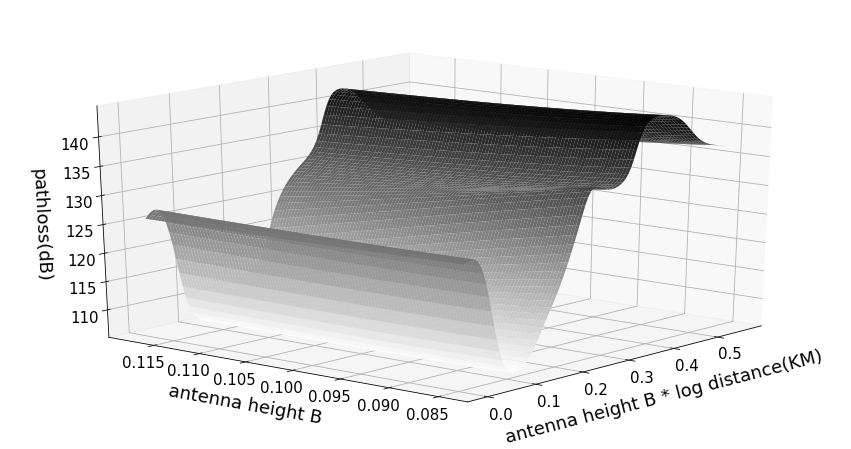

3D graph for log distance and log antenna height B ratio - trainset #5
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'extendedHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency   logHeightB   logHeightM  extendedHeightTratio  logAntennaMulLogDistance
count  1.00000e+04   1.00000e+04  10000.00000  10000.00000           1.00000e+04               10000.00000
mean   3.06252e-01   3.02692e-01      0.10106      0.30103           4.63925e-01                   0.28070
std    5.55139e-17   5.55139e-17      0.00965      0.00000           1.11028e-16                   0.16351
min    3.06252e-01   3.02692e-01      0.08451      0.30103           4.63925e-01                   0.00032
25%    3.06252e-01   3.02692e-01      0.09278      0.30103           4.63925e-01                   0.14051
50%    3.06252e-01   3.02692e-01      0.10106      0.30103           4.63925e-01                   0.28070
75%    3.06

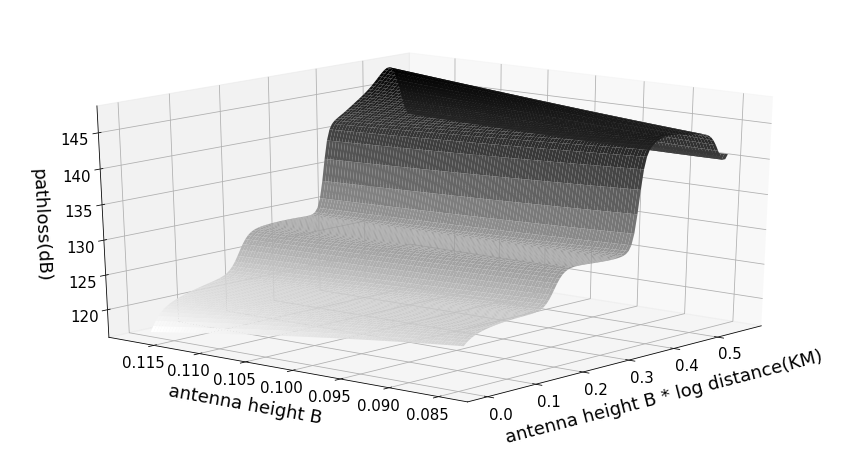

In [25]:
%autoreload
i = 1
for X_train,y_train,X_test,y_test, trainError, testError in dataSet:
    print("3D graph for log distance and log antenna height B ratio - trainset #{}".format(i))
    targetCols = ['logAntennaMulLogDistance', 'logHeightB']
    xLabel,yLabel,zLabel = "antenna height B(M) * log distance(KM)","antenna height B","pathloss(dB)"
    data = makeXforGraph(pd.DataFrame(X_train, columns=['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'extendedHeightTratio', 'logAntennaMulLogDistance']),
                         pd.DataFrame(y_train, columns=['pathloss']), targetCols)

    model = pickle.load(open("model/ann_model_"+ str(i) +".sav", 'rb'))

    graphX = data[0]
    graphY = data[1]
    train_3d_graph(model, graphX, graphY, targetCols, xLabel, yLabel, zLabel)
    i+=1

Equation Derivation for trainset #1
Group-  0.26Ghz Data shape:(2120, 7)
Group-  0.31Ghz Data shape:(2143, 7)
Group-  0.34Ghz Data shape:(2066, 7)
ANN-Model-1-train error(RMSE): 10.742817361125441
ANN-Model-1-test error(RMSE): 11.162634360372376
MultiLinear-1-train error(RMSE): 12.663681666353973
MultiLinear-1-test error(RMSE): 12.8276655485623

Objective Function with manual normalization data
L_pathloss = (-81.77 + 104.48log_hb)log_d + 2746.30log_f + -2650.92log_hb +   0.00log_hm +  16.63log_(h_tb/h_tm) +  55.46
RMSE(ANN-MultiLinear): 6.6092860609129


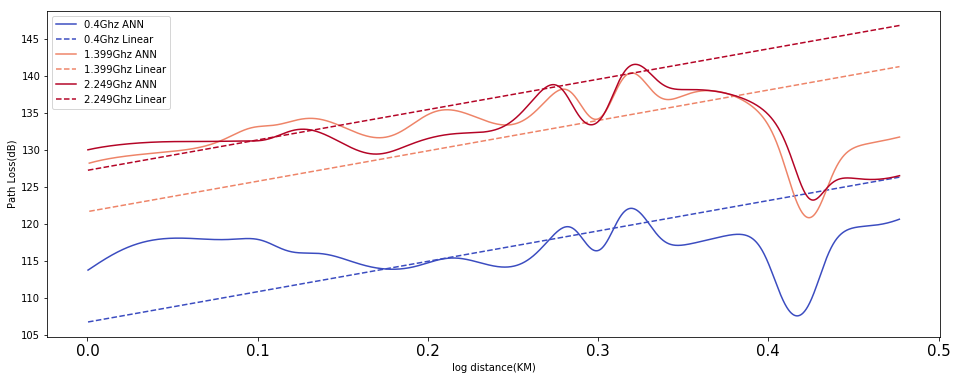

Equation Derivation for trainset #2
Group-  0.26Ghz Data shape:(2131, 7)
Group-  0.31Ghz Data shape:(2125, 7)
Group-  0.34Ghz Data shape:(2073, 7)
ANN-Model-2-train error(RMSE): 10.723734720322145
ANN-Model-2-test error(RMSE): 11.10289963152522
MultiLinear-2-train error(RMSE): 12.759834730563103
MultiLinear-2-test error(RMSE): 12.43900355118197

Objective Function with manual normalization data
L_pathloss = (-81.90 + 105.18log_hb)log_d + 2678.23log_f + -2709.42log_hb +   0.00log_hm +  16.74log_(h_tb/h_tm) +  57.87
RMSE(ANN-MultiLinear): 6.871303044358431


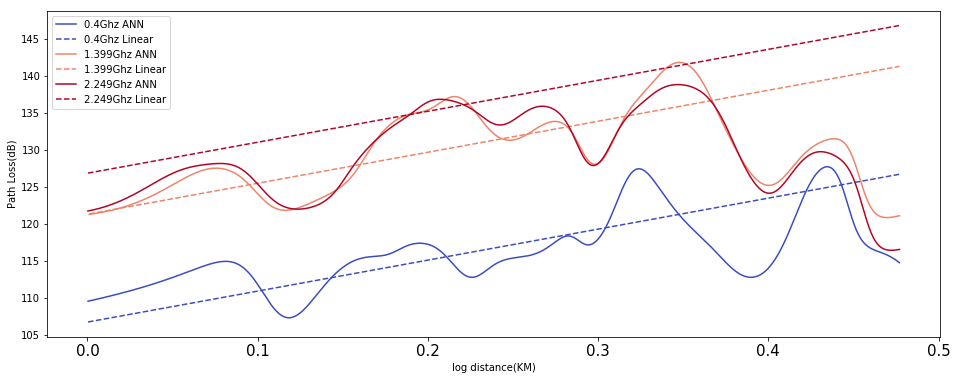

Equation Derivation for trainset #3
Group-  0.26Ghz Data shape:(2112, 7)
Group-  0.31Ghz Data shape:(2160, 7)
Group-  0.34Ghz Data shape:(2058, 7)
ANN-Model-3-train error(RMSE): 10.925526445660676
ANN-Model-3-test error(RMSE): 10.979310873193645
MultiLinear-3-train error(RMSE): 12.731683985197312
MultiLinear-3-test error(RMSE): 12.560152899610387

Objective Function with manual normalization data
L_pathloss = (-75.77 +  99.08log_hb)log_d + 2695.05log_f + -2362.76log_hb +   0.00log_hm +  16.71log_(h_tb/h_tm) +  53.81
RMSE(ANN-MultiLinear): 6.513433570912303


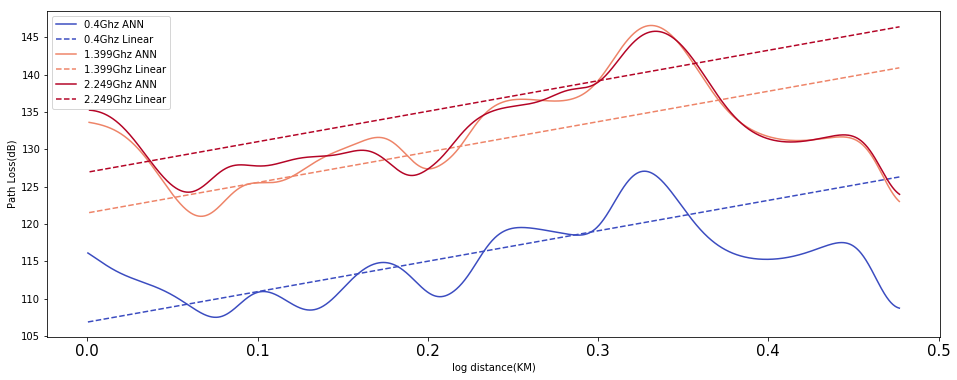

Equation Derivation for trainset #4
Group-  0.26Ghz Data shape:(2122, 7)
Group-  0.31Ghz Data shape:(2150, 7)
Group-  0.34Ghz Data shape:(2058, 7)
ANN-Model-4-train error(RMSE): 11.118586474894286
ANN-Model-4-test error(RMSE): 11.523713118118053
MultiLinear-4-train error(RMSE): 12.673170738333097
MultiLinear-4-test error(RMSE): 12.798094035232172

Objective Function with manual normalization data
L_pathloss = (-85.96 + 109.97log_hb)log_d + 2768.38log_f + -2762.32log_hb +   0.00log_hm +  16.26log_(h_tb/h_tm) +  55.67
RMSE(ANN-MultiLinear): 6.038291586341018


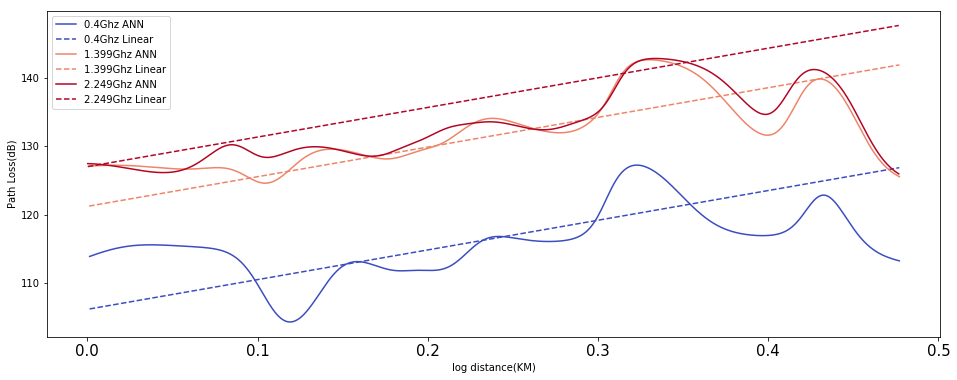

Equation Derivation for trainset #5
Group-  0.26Ghz Data shape:(2155, 7)
Group-  0.31Ghz Data shape:(2142, 7)
Group-  0.34Ghz Data shape:(2033, 7)
ANN-Model-5-train error(RMSE): 11.16646750606209
ANN-Model-5-test error(RMSE): 11.577605475459663
MultiLinear-5-train error(RMSE): 12.647246146470104
MultiLinear-5-test error(RMSE): 12.891539556251109

Objective Function with manual normalization data
L_pathloss = (-79.39 + 103.69log_hb)log_d + 2719.50log_f + -2611.54log_hb +   0.00log_hm +  16.32log_(h_tb/h_tm) +  55.55
RMSE(ANN-MultiLinear): 5.879966814864492


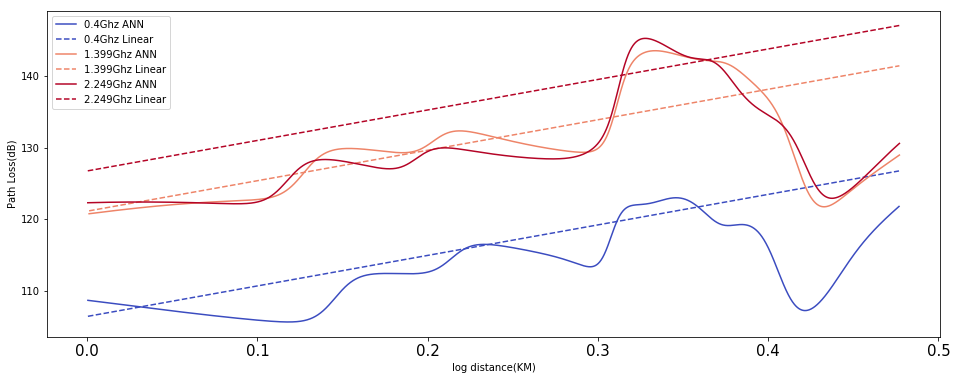

In [9]:
%autoreload
i = 1
for X_train, y_train, X_test, y_test, trainError, testError in dataSet:
    print("="*120)
    print("Equation Derivation for trainset #{}".format(i))
    data = makeXforGraphWithGroupingFrequency(pd.DataFrame(X_train, columns=['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'extendedHeightTratio', 'logAntennaMulLogDistance']),
                         pd.DataFrame(y_train, columns=['pathloss']), ['logHeightB', 'logHeightM', 'extendedHeightTratio'])

    ANNmodel = pickle.load(open("model/ann_model_"+ str(i) +".sav", 'rb'))
    ANNPred = ANNmodel.predict(X_train)
    
    linearModel = Ridge(alpha=0.001).fit(X_train, ANNPred)     
    linearPredTrain = linearModel.predict(X_train)
    linearPredTest = linearModel.predict(X_test)
    
    RMSE_LIN_TRAIN = np.sqrt(mean_squared_error(linearPredTrain, y_train))
    RMSE_LIN_TEST = np.sqrt(mean_squared_error(linearPredTest, y_test))
    
    RMSE_LIN_ANN = np.sqrt(mean_squared_error(ANNPred, linearPredTrain))

    print("ANN-Model-"+str(i)+"-train error(RMSE):", trainError)
    print("ANN-Model-"+str(i)+"-test error(RMSE):", testError)  
    print("MultiLinear-"+str(i)+"-train error(RMSE):",RMSE_LIN_TRAIN)
    print("MultiLinear-"+str(i)+"-test error(RMSE):",RMSE_LIN_TEST)
    
    if manual_normalize:
        print("\nObjective Function with manual normalization data")
        print("L_pathloss = ({:6.2f} + {:6.2f}log_hb)log_d + {:6.2f}log_f + {:6.2f}log_hb + {:6.2f}log_hm + {:6.2f}log_(h_tb + h_b/h_tm + h_m) + {:6.2f}"\
              .format(linearModel.coef_[0],linearModel.coef_[5],linearModel.coef_[1]*10,\
                      linearModel.coef_[2]*10,linearModel.coef_[3],linearModel.coef_[4],linearModel.intercept_))    
    else:
        print("L_pathloss = ({:6.2f} + {:6.2f}log_hb)log_d + {:6.2f}log_f + {:6.2f}log_hb + {:6.2f}log_hm + {:6.2f}log_(h_tb + h_b/h_tm + h_m) + {:6.2f}"\
              .format(linearModel.coef_[0],linearModel.coef_[5],linearModel.coef_[1],\
                      linearModel.coef_[2],linearModel.coef_[3],linearModel.coef_[4],linearModel.intercept_))

    print("RMSE(ANN-MultiLinear):", RMSE_LIN_ANN)
    graphX = data[0]
    graphY = data[1]
    ann_linear_compare_graph(ANNmodel, linearModel, graphX, graphY)

    i+=1